In [2]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import seaborn as sns
from pyMRI.utils import RMSE

In [3]:
original_s0s = np.array([10.0, 15.0, 20.0, 25.0])
original_omegas = pymri.hz_to_rad(np.array([25.0, 75.0, 125.0, 175.0])) # hz
original_t2s = np.array([0.25, 0.5, 0.75, 1.0])
# phis__ = np.array([np.pi/3, np.pi/4, np.pi/5, np.pi/6])
original_phis = np.array([0.0, 0.0, 0.0, 0.0])

n_points = 2048
t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 4.096, n_points, 3.0)

print(original_omegas)
print(t0, tn, dt)



[ 157.07963268  471.23889804  785.3981634  1099.55742876]
0.0 4.096 0.002


(0.0, 200.0)

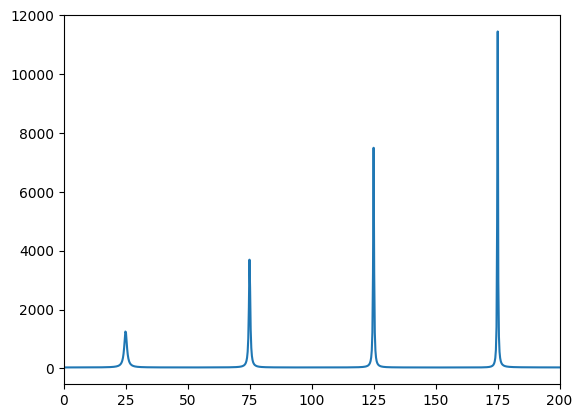

In [4]:
pop = pymri.population(original_omegas, original_t2s, original_s0s, original_phis)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
freqs = pymri.f_from_chem_shift(freqs, B0)
sig = np.fft.ifft(np.fft.ifftshift(sig_fft))

plt.plot(freqs, sig_fft.real)
plt.xlim(0.0, 200.0)

In [5]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [6]:
_, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
reconstructed_s0s, reconstructed_phis, reconstructed_omegas, reconstructed_t2s = pymri.calculate_variables_from_z_and_r(z, r, dt)
reconstructed_t2s = 1/reconstructed_t2s

[-1.20000000e-01 -1.10000000e-01 -1.00000000e-01 -9.00000000e-02
 -8.00000000e-02 -7.00000000e-02 -6.00000000e-02 -5.00000000e-02
 -4.00000000e-02 -3.00000000e-02 -2.00000000e-02 -1.00000000e-02
 -5.55111512e-17  1.00000000e-02  2.00000000e-02  3.00000000e-02
  4.00000000e-02  5.00000000e-02  6.00000000e-02  7.00000000e-02
  8.00000000e-02  9.00000000e-02  1.00000000e-01  1.10000000e-01
  1.20000000e-01  1.30000000e-01  1.40000000e-01  1.50000000e-01
  1.60000000e-01  1.70000000e-01  1.80000000e-01  1.90000000e-01
  2.00000000e-01  2.10000000e-01  2.20000000e-01  2.30000000e-01
  2.40000000e-01  2.50000000e-01]


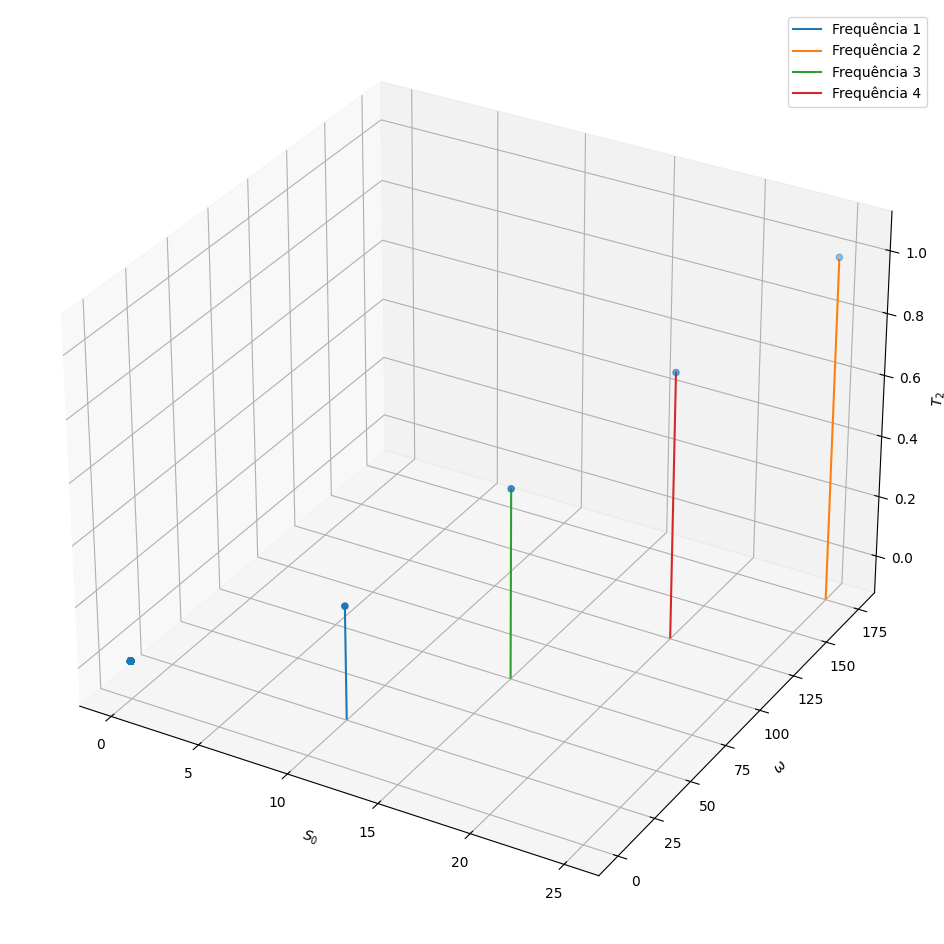

In [7]:
fig_2 = plt.figure(figsize=(12, 12))
ax_2 = fig_2.add_subplot(projection='3d')

z1 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][0], 0.01)
z2 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][1], 0.01)
z3 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][2], 0.01)
z4 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][3], 0.01)

y1 = np.full_like(z1, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][0]))
y2 = np.full_like(z2, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][1]))
y3 = np.full_like(z3, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][2]))
y4 = np.full_like(z4, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][3]))

x1 = np.full_like(z1, reconstructed_s0s[reconstructed_s0s != 0.0][0])
x2 = np.full_like(z2, reconstructed_s0s[reconstructed_s0s != 0.0][1])
x3 = np.full_like(z3, reconstructed_s0s[reconstructed_s0s != 0.0][2])
x4 = np.full_like(z4, reconstructed_s0s[reconstructed_s0s != 0.0][3])

print(z1)

# Filtragem
filtered_s0_2 =  reconstructed_s0s
filtered_phi_2 = reconstructed_phis
filtered_omega_2 = reconstructed_omegas
filtered_t2_2 = reconstructed_t2s
ax_2.scatter(reconstructed_s0s, pymri.rad_to_hz(reconstructed_omegas), reconstructed_t2s) #(w, T2, s0)
ax_2.plot(x1, y1, z1, label = "Frequência 1")
ax_2.plot(x2, y2, z2, label = "Frequência 2")
ax_2.plot(x3, y3, z3, label = "Frequência 3")
ax_2.plot(x4, y4, z4, label = "Frequência 4")

ax_2.set_zlim(-0.1, 1.1)


ax_2.set_xlabel(r"$S_0$")
ax_2.set_ylabel(r"$\omega$")
ax_2.set_zlabel(r"$T_2$")

plt.legend()

plt.show()

### Adição de ruído

In [29]:
scales = np.array([0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.001, 0.00075, 0.0005, 0.00025, 0.0001, 0.0])
scales = 10000*scales
windows = np.arange(5.0, 105.0, 5.0)
loc = 0.0

print(scales.size, windows.size)
n_avgs = 10

13 20


In [33]:
noise = np.random.normal(loc, scales[-1], 2048) + 1*np.random.normal(loc, scales[-1], 2048)

642.3020921444958


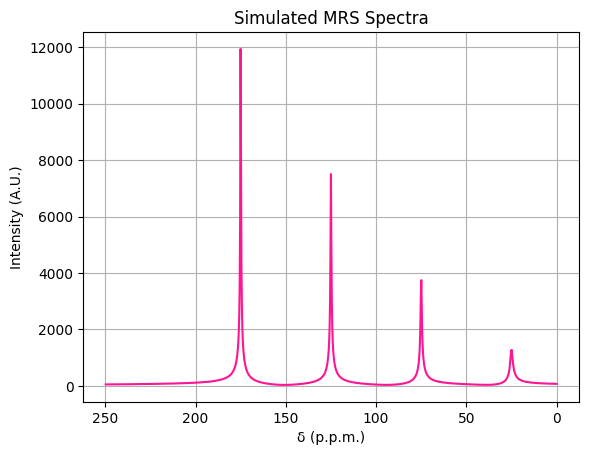

In [34]:
pymri.plot_chem_shifts(freqs, sig_fft + noise)
print(pymri.snr(sig_fft + noise))

In [35]:
shape = (n_avgs, scales.size, L_)
s0s, phis, omegas, t2s = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
snrs = np.zeros((n_avgs, scales.size))

In [46]:
rerun = False
ends = ["", "_2"]
filename_end = ends[0]
folder_name = "files/"
subfolder_name = "clusters_2/"

In [47]:
if rerun == True:
    for i in range(n_avgs):
        for j in range(scales.size):
                noise = np.random.normal(loc, scales[j], 2048) + 1j*np.random.normal(loc, scales[j], 2048)
                c_sig_fft = sig_fft + noise
                snrs[i, j] = pymri.snr(c_sig_fft)

                c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

                _, z, r = pymri.filter_sig(c_sig, L, noise_threshold, rcond=1e-7, return_poles_and_res=True, return_full_arrays=True)
                s0s[i, j, :], phis[i, j, :], omegas[i, j, :], t2s[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
                t2s[i, j, :] = 1/t2s[i, j, :]
                        

In [43]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s" + filename_end, s0s)
    np.save(folder_name + subfolder_name + "phis" + filename_end, phis)
    np.save(folder_name + subfolder_name + "omegas" + filename_end, omegas)
    np.save(folder_name + subfolder_name + "t2s" + filename_end, t2s)
    np.save(folder_name + subfolder_name + "snrs" + filename_end, snrs)
    np.save(folder_name + subfolder_name + "scales" + filename_end, scales)

In [48]:
if rerun == False:
    s0s = np.load(folder_name + subfolder_name + "s0s" + filename_end + ".npy")
    phis = np.load(folder_name + subfolder_name + "phis" + filename_end + ".npy")
    omegas = np.load(folder_name + subfolder_name + "omegas" + filename_end + ".npy")
    t2s = np.load(folder_name + subfolder_name + "t2s" + filename_end + ".npy")
    snrs = np.load(folder_name + subfolder_name + "snrs" + filename_end + ".npy")
    scales = np.load(folder_name + subfolder_name + "scales" + filename_end + ".npy")

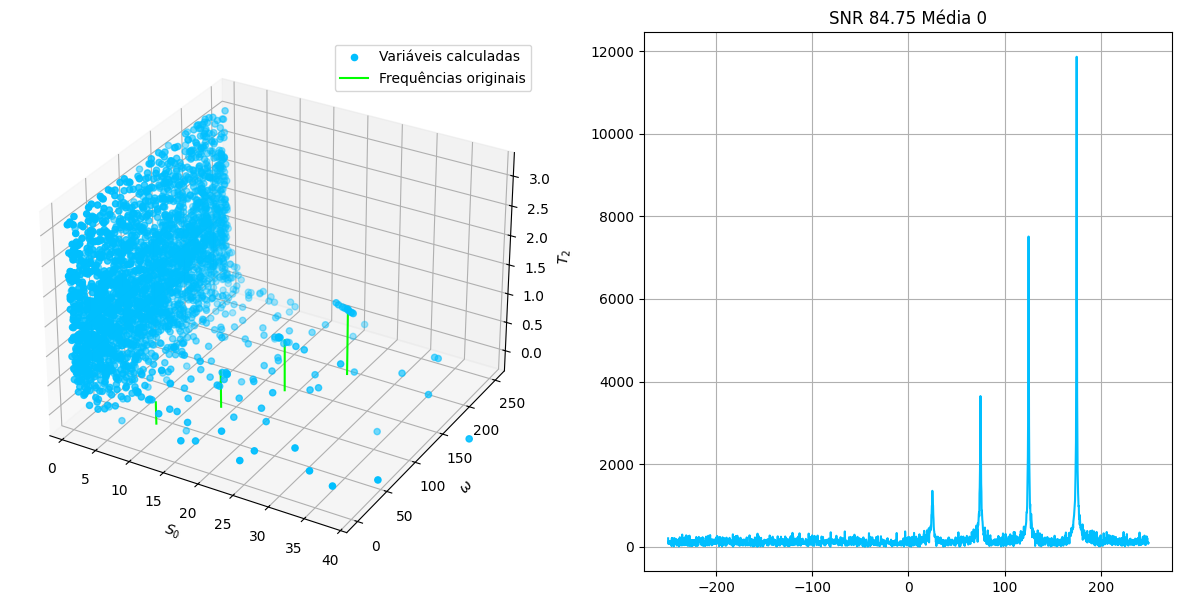

In [90]:
fig_3 = plt.figure(figsize=(15, 7))
ax_3 = fig_3.add_subplot(1, 2, 1, projection='3d')

i_scale = 4


for i in range(s0s.shape[0]):
    if(i_scale != 12): # Excluindo o primeiro caso que não tem ruído e irá trazer problemas para a filtragem de t2
        omega_filter = pymri.filter_omegas(omegas[i, i_scale, :], dt)
        t2_filter = pymri.filter_t2(t2s[i, i_scale, :])

        filter = pymri.compose_filters((omega_filter, t2_filter))
    else: 
        filter = np.full_like(L_, True, dtype = bool)

    # Filtragem
    filtered_s0 =  s0s[i, i_scale, :][filter]
    filtered_phi = phis[i, i_scale, :][filter]
    filtered_omega = omegas[i, i_scale, :][filter]
    filtered_t2 = t2s[i, i_scale, :][filter]
    # ax.scatter(filtered_omega, filtered_t2, filtered_s0)
    ax_3.scatter(filtered_s0, pymri.rad_to_hz(filtered_omega), filtered_t2, c = "deepskyblue", label = int(i == 0)*"Variáveis calculadas") #(w, T2, s0)

ax_3.set_xlim(-1.0, 40.0)

ax_3.plot(x1, y1, z1, label = "Frequências originais", c = "lime")
ax_3.plot(x2, y2, z2, c = "lime")
ax_3.plot(x3, y3, z3, c = "lime")
ax_3.plot(x4, y4, z4, c = "lime")
    

ax_3.set_xlabel(r"$S_0$")
ax_3.set_ylabel(r"$\omega$")
ax_3.set_zlabel(r"$T_2$")

ax_3.legend()


ax_3 = fig_3.add_subplot(1, 2, 2)

i_avg = 0
if(i_scale == 12):
    zero_filter = t2s[i_avg, i_scale, :] != 0.0
else:
    zero_filter = np.full_like(t2s[i_avg, i_scale, :], True, dtype = bool)


ex_pop = pymri.population(omegas[i_avg, i_scale, :][zero_filter], 
                          t2s[i_avg, i_scale, :][zero_filter], 
                          s0s[i_avg, i_scale, :][zero_filter], 
                          phis[i_avg, i_scale, :][zero_filter])
ex_sig, t = pymri.population_transverse_decay(t0, tn, dt, ex_pop)
ex_freqs, ex_sig_fft = pymri.fourier_spectrum(ex_sig, dt, B0, unit = "hz")
ax_3.plot(ex_freqs, np.abs(ex_sig_fft), c = "deepskyblue")
ax_3.set_title(f"SNR {np.round(snrs[i_avg, i_scale], 2)} Média {i_avg}")
ax_3.grid()

plt.show()

Foi comentado que avaliar a densidade de incidência de certos pontos pode ser um caminho interessante. A ideia: definir um raio de uma esfera ao redor dos pontos aonde deveriam estar os 4 picos originais. Dentro dessa esfera, avaliar a incidência de pontos após n rodadas (n_avgs = 10 por exemplo). Procurar por incidências altas dentro dessa esfera, na esperança de encontrar algum padrão que indique como os picos se comportam naquela situação.